# Importing Libraries

In [1]:
import os
import torch
import collections
import pickle
import numpy as np
import torch.nn.functional as F
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
from torch import nn
from torch import optim
from shutil import copy
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from torchvision import datasets, transforms, models

# Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Looking for GPU

In [3]:
# Check whether GPU is available and if it is then use GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Unziping Dataset to Colab

In [4]:
!unzip drive/MyDrive/Thesis/dataset.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/train/strawberry_shortcake/2234323.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2239071.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2244021.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2245360.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2259069.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2259652.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2266581.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2271614.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2275253.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2282398.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2282550.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2288472.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2291293.jpg  
  inflating: ./dataset/train/strawberry_shortcake/2292632.jpg  
  inflating: ./dataset/train/strawberry_shortcake/230

# Data Augmentation

In [5]:
# Data augmentation
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(45),
                                       transforms.RandomAffine(45),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Use 10-crop for Test Time Augmentation
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.TenCrop(224),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(crop) for crop in crops]))])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder("dataset/train", transform=train_transforms)
test_data = datasets.ImageFolder("dataset/test", transform=test_transforms)

# Using the image datasets and the tranforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=16, shuffle=True)

In [6]:
# Print out some data stats
print('Number of training images:', len(train_data))
print('Number of testing images:', len(test_data))

with open('drive/MyDrive/Thesis/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
print('Number of classes: ', len(classes))    

# Analyzing the shape of one batch
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print('Shape of first batch of training images:', train_images.shape)
print('Shape of first batch of test images:', test_images.shape) # 5-D array because of 10 crops

Number of training images: 75749
Number of testing images: 25250
Number of classes:  101
Shape of first batch of training images: torch.Size([64, 3, 224, 224])
Shape of first batch of test images: torch.Size([16, 10, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

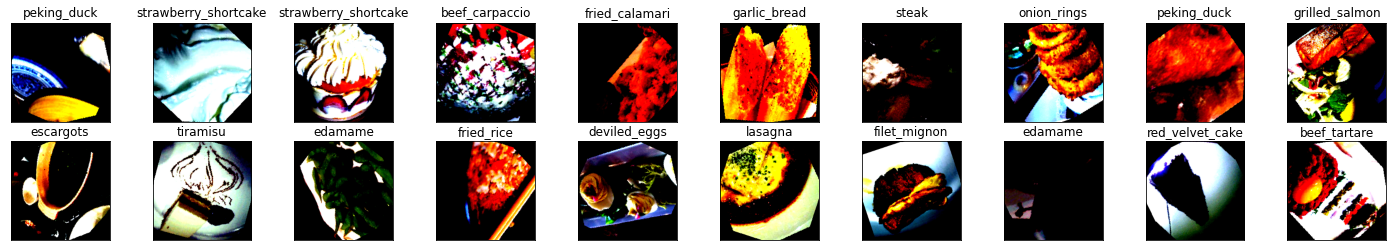

In [7]:
# Visualize some sample training data after Data augmentation

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

# Defining Model

In [8]:
# Load the ResNet-50 model pretraned on ImageNet 
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# Freeze the initial layers
for param in model.parameters():
  param.requires_grad = False
  
# Replace the final fully connected layer with new fully connected layer of 101 neurons
classifier = nn.Linear(2048, 101)
model.fc = classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training Loop

In [ ]:
def training_loop(model, criterion, optimizer, scheduler, train_on_gpu, total_epochs, current_epoch, valid_loss, train_loader, val_loader, folder, train_losses, train_accuracies, val_losses, val_accuracies):

  # Print training info
  print('=' * 60)
  print('||  Training with ' + folder + ' for', total_epochs , 'epochs and lr:', optimizer.param_groups[0]['lr'])
  print("||  Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
  print('=' * 60)

  # Move the model to GPU if CUDA is available
  if train_on_gpu:
      model.cuda()

  valid_loss_min = valid_loss # track change in validation loss
  lr = optimizer.param_groups[0]['lr']

  for epoch in range(current_epoch + 1,  total_epochs + 1):
      # Keep track of training and validation loss
      train_loss, train_accuracy, val_loss, val_accuracy = 0.0, 0.0, 0.0, 0.0
      print('_' * 60)
      print(f'Epoch {epoch}/{total_epochs} with learning rate {lr}')
      
      ###################   
      # Train the model #   
      ###################    
      model.train()
      for data, target in tq.tqdm(train_loader):
          # Move tensors to GPU if CUDA is available
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          # Clear the gradients of all optimized variables
          optimizer.zero_grad()
          # Forward pass: compute predicted outputs
          output = model(data)
          # Calculate the loss
          loss = criterion(output, target)
          # Backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          # Calculate training accuracy
          top_p, top_class = output.topk(1, dim=1)
          equals = top_class == target.view(*top_class.shape)
          train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
          
      ######################    
      # Validate the model #    
      ######################     
      model.eval()
      with torch.no_grad():
          for data, target in tq.tqdm(val_loader):
              # Move tensors to GPU if CUDA is available
              if train_on_gpu:
                  data, target = data.cuda(), target.cuda()
              ## For 10-crop Testing
              bs, ncrops, c, h, w = data.size()
              # Forward pass: compute predicted outputs 
              temp_output = model(data.view(-1, c, h, w))
              output = temp_output.view(bs, ncrops, -1).mean(1)
              # Calculate the loss
              loss = criterion(output, target)
              # Update average validation loss 
              val_loss += loss.item()*data.size(0)
              # Calculate validation accuracy
              top_p, top_class = output.topk(1, dim=1)
              equals = top_class == target.view(*top_class.shape)
              val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
      

      # Calculate average losses and accuracies
      train_loss = train_loss/len(train_loader.dataset)
      train_accuracy = train_accuracy/len(train_loader.dataset)
      val_loss = val_loss/len(val_loader.dataset)
      val_accuracy = val_accuracy/len(val_loader.dataset)

      # Update Lists
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      # Learning rate scheduler step
      scheduler.step(val_accuracy) 
      
      # print training/validation statistics 
      print('Train Loss: {:.4f} \tTrain Accuracy: {:.4f} \t\tValid Loss: {:.4f} \tValid Accuracy: {:.4f}'.format(train_loss, train_accuracy, val_loss, val_accuracy))
      
      # Save model if validation loss has decreased
      if val_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, val_loss))   
          checkpoint = {"model": model,
                        "criterion": criterion,
                        "epochs": epoch,
                        "optimizer_state": optimizer.state_dict(),
                        "model_state": model.state_dict(),
                        "valid_loss_min": val_loss,
                        "valid_accuracy": val_accuracy}

          # Save model in colab
          torch.save(checkpoint, 'best_so_far_checkpoint.pth')
          valid_loss_min = val_loss

          # Save model to google drive
          model_save_name = 'resnet50model.pth'
          path = F"drive/MyDrive/Thesis/checkpoints/{model_save_name}" 
          torch.save(checkpoint, path)

      # Save Lists to Drive
      with open('drive/MyDrive/Thesis/log/train_losses.pkl', 'wb') as fp:   
          pickle.dump(train_losses, fp)
      with open('drive/MyDrive/Thesis/log/train_accuracies.pkl', 'wb') as fp:   
          pickle.dump(train_accuracies, fp)
      with open('drive/MyDrive/Thesis/log/val_losses.pkl', 'wb') as fp:   
          pickle.dump(val_losses, fp)
      with open('drive/MyDrive/Thesis/log/val_accuracies.pkl', 'wb') as fp:   
          pickle.dump(val_accuracies, fp)

      torch.cuda.empty_cache()


# Training Process (Frozen Weights)

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

In [ ]:
# Loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Optimizer (stochastic gradient descent with momentum)
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# Learning rate scheduler 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.2)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 10, 0, np.Inf, train_loader, test_loader, 'frozen', train_losses, train_accuracies, val_losses, val_accuracies)

||  Training with frozen for 10 epochs and lr: 0.01
||  Trainable parameters: 206949
____________________________________________________________
Epoch 1/10 with learning rate 0.01


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Loss: 3.1792 	Train Accuracy: 0.2718 		Valid Loss: 2.3497 	Valid Accuracy: 0.4232
Validation loss decreased (inf --> 2.349676).  Saving model ...
____________________________________________________________
Epoch 2/10 with learning rate 0.01



Train Loss: 2.7663 	Train Accuracy: 0.3473 		Valid Loss: 2.2763 	Valid Accuracy: 0.4280
Validation loss decreased (2.349676 --> 2.276341).  Saving model ...
____________________________________________________________
Epoch 3/10 with learning rate 0.01



Train Loss: 2.6820 	Train Accuracy: 0.3631 		Valid Loss: 2.1826 	Valid Accuracy: 0.4522
Validation loss decreased (2.276341 --> 2.182602).  Saving model ...
____________________________________________________________
Epoch 4/10 with learning rate 0.01



Train Loss: 2.6444 	Train Accuracy: 0.3729 		Valid Loss: 2.0962 	Valid Accuracy: 0.4798
Validation loss decreased (2.182602 --> 2.096223).  Saving model ...
____________________________________________________________
Epoch 5/10 with learning rate 0.01



Train Loss: 2.6131 	Train Accuracy: 0.3797 		Valid Loss: 1.9995 	Valid Accuracy: 0.5018
Validation loss decreased (2.096223 --> 1.999462).  Saving model ...
____________________________________________________________
Epoch 6/10 with learning rate 0.01



Train Loss: 2.5851 	Train Accuracy: 0.3849 		Valid Loss: 2.0212 	Valid Accuracy: 0.4922
____________________________________________________________
Epoch 7/10 with learning rate 0.01



Train Loss: 2.5709 	Train Accuracy: 0.3891 		Valid Loss: 2.0487 	Valid Accuracy: 0.4741
____________________________________________________________
Epoch 8/10 with learning rate 0.01



Train Loss: 2.5396 	Train Accuracy: 0.3946 		Valid Loss: 1.9760 	Valid Accuracy: 0.4970
Validation loss decreased (1.999462 --> 1.976031).  Saving model ...
____________________________________________________________
Epoch 9/10 with learning rate 0.01



Train Loss: 2.5283 	Train Accuracy: 0.3962 		Valid Loss: 1.9979 	Valid Accuracy: 0.4924
____________________________________________________________
Epoch 10/10 with learning rate 0.01



Train Loss: 2.5209 	Train Accuracy: 0.3981 		Valid Loss: 1.9313 	Valid Accuracy: 0.5031
Validation loss decreased (1.976031 --> 1.931312).  Saving model ...


# Training Process (Unfrozen Weights) I

In [ ]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

# Load the lists of losses and accuracies and use only the saved values
with open('drive/MyDrive/Thesis/log/train_losses.pkl', 'rb') as fp:   
    train_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/train_accuracies.pkl', 'rb') as fp:   
    train_accuracies = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_losses.pkl', 'rb') as fp:   
    val_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_accuracies.pkl', 'rb') as fp:   
    val_accuracies = pickle.load(fp)

train_losses, train_accuracies, val_losses, val_accuracies = train_losses[:num_epoch], train_accuracies[:num_epoch], val_losses[:num_epoch], val_accuracies[:num_epoch]

We have reached the 10th epoch and a validation loss of 1.9313


In [ ]:
# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# specify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=4)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 40, num_epoch, valid_loss, train_loader, test_loader, 'unfrozen', train_losses, train_accuracies, val_losses, val_accuracies)

||  Training with unfrozen for 40 epochs and lr: 0.01
||  Trainable parameters: 23714981
____________________________________________________________
Epoch 11/40 with learning rate 0.01


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Loss: 2.2771 	Train Accuracy: 0.4447 		Valid Loss: 1.4047 	Valid Accuracy: 0.6233
Validation loss decreased (1.931312 --> 1.404728).  Saving model ...
____________________________________________________________
Epoch 12/40 with learning rate 0.01



Train Loss: 1.8473 	Train Accuracy: 0.5377 		Valid Loss: 1.1865 	Valid Accuracy: 0.6813
Validation loss decreased (1.404728 --> 1.186488).  Saving model ...
____________________________________________________________
Epoch 13/40 with learning rate 0.01



Train Loss: 1.6778 	Train Accuracy: 0.5750 		Valid Loss: 1.0339 	Valid Accuracy: 0.7187
Validation loss decreased (1.186488 --> 1.033852).  Saving model ...
____________________________________________________________
Epoch 14/40 with learning rate 0.01



Train Loss: 1.5725 	Train Accuracy: 0.6011 		Valid Loss: 0.9560 	Valid Accuracy: 0.7383
Validation loss decreased (1.033852 --> 0.956029).  Saving model ...
____________________________________________________________
Epoch 15/40 with learning rate 0.01



Train Loss: 1.4914 	Train Accuracy: 0.6188 		Valid Loss: 0.9637 	Valid Accuracy: 0.7359
____________________________________________________________
Epoch 16/40 with learning rate 0.01



Train Loss: 1.4248 	Train Accuracy: 0.6339 		Valid Loss: 0.9351 	Valid Accuracy: 0.7433
Validation loss decreased (0.956029 --> 0.935065).  Saving model ...
____________________________________________________________
Epoch 17/40 with learning rate 0.01



Train Loss: 1.3741 	Train Accuracy: 0.6458 		Valid Loss: 0.8673 	Valid Accuracy: 0.7566
Validation loss decreased (0.935065 --> 0.867348).  Saving model ...
____________________________________________________________
Epoch 18/40 with learning rate 0.01



Train Loss: 1.3292 	Train Accuracy: 0.6546 		Valid Loss: 0.8501 	Valid Accuracy: 0.7681
Validation loss decreased (0.867348 --> 0.850109).  Saving model ...
____________________________________________________________
Epoch 19/40 with learning rate 0.01



Train Loss: 1.2781 	Train Accuracy: 0.6682 		Valid Loss: 0.8234 	Valid Accuracy: 0.7740
Validation loss decreased (0.850109 --> 0.823385).  Saving model ...
____________________________________________________________
Epoch 20/40 with learning rate 0.01



Train Loss: 1.2412 	Train Accuracy: 0.6769 		Valid Loss: 0.7669 	Valid Accuracy: 0.7874
Validation loss decreased (0.823385 --> 0.766897).  Saving model ...
____________________________________________________________
Epoch 21/40 with learning rate 0.01



Train Loss: 1.2046 	Train Accuracy: 0.6846 		Valid Loss: 0.7539 	Valid Accuracy: 0.7906
Validation loss decreased (0.766897 --> 0.753909).  Saving model ...
____________________________________________________________
Epoch 22/40 with learning rate 0.01


# Training Process (Unfrozen Weights) II
Continuation of Training due to Colab Disconnection

In [ ]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

# Load the lists of losses and accuracies and use only the saved values
with open('drive/MyDrive/Thesis/log/train_losses.pkl', 'rb') as fp:   
    train_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/train_accuracies.pkl', 'rb') as fp:   
    train_accuracies = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_losses.pkl', 'rb') as fp:   
    val_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_accuracies.pkl', 'rb') as fp:   
    val_accuracies = pickle.load(fp)

train_losses, train_accuracies, val_losses, val_accuracies = train_losses[:num_epoch], train_accuracies[:num_epoch], val_losses[:num_epoch], val_accuracies[:num_epoch]

We have reached the 21th epoch and a validation loss of 0.7539


In [ ]:
# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()
# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# specify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 40, num_epoch, valid_loss, train_loader, test_loader, 'unfrozen', train_losses, train_accuracies, val_losses, val_accuracies)

||  Training with unfrozen for 40 epochs and lr: 0.01
||  Trainable parameters: 23714981
____________________________________________________________
Epoch 22/40 with learning rate 0.01


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Loss: 1.1655 	Train Accuracy: 0.6935 		Valid Loss: 0.7084 	Valid Accuracy: 0.8036
Validation loss decreased (0.753909 --> 0.708380).  Saving model ...
____________________________________________________________
Epoch 23/40 with learning rate 0.01



Train Loss: 1.1458 	Train Accuracy: 0.6996 		Valid Loss: 0.6821 	Valid Accuracy: 0.8105
Validation loss decreased (0.708380 --> 0.682089).  Saving model ...
____________________________________________________________
Epoch 24/40 with learning rate 0.01



Train Loss: 1.1117 	Train Accuracy: 0.7074 		Valid Loss: 0.6862 	Valid Accuracy: 0.8101
____________________________________________________________
Epoch 25/40 with learning rate 0.01



Train Loss: 1.0858 	Train Accuracy: 0.7124 		Valid Loss: 0.7140 	Valid Accuracy: 0.8017
____________________________________________________________
Epoch 26/40 with learning rate 0.01


KeyboardInterrupt: ignored

# Training Process (Unfrozen Weights) IIΙ
Continuation of Training due to Colab Disconnection

In [ ]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

# Load the lists of losses and accuracies and use only the saved values
with open('drive/MyDrive/Thesis/log/train_losses.pkl', 'rb') as fp:   
    train_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/train_accuracies.pkl', 'rb') as fp:   
    train_accuracies = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_losses.pkl', 'rb') as fp:   
    val_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_accuracies.pkl', 'rb') as fp:   
    val_accuracies = pickle.load(fp)

train_losses, train_accuracies, val_losses, val_accuracies = train_losses[:num_epoch], train_accuracies[:num_epoch], val_losses[:num_epoch], val_accuracies[:num_epoch]

We have reached the 25th epoch and a validation loss of 0.5181


In [ ]:
# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()
# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
# specify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', threshold=0.008, factor=0.2, patience=3, verbose=True)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 40, num_epoch, valid_loss, train_loader, test_loader, 'unfrozen', train_losses, train_accuracies, val_losses, val_accuracies)

||  Training with unfrozen for 40 epochs and lr: 0.002
||  Trainable parameters: 23714981
____________________________________________________________
Epoch 26/40 with learning rate 0.002


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


RuntimeError: ignored

# Training Process (Unfrozen Weights) IV
Continuation of Training due to Colab Disconnection

In [ ]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

# Load the lists of losses and accuracies and use only the saved values
with open('drive/MyDrive/Thesis/log/train_losses.pkl', 'rb') as fp:   
    train_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/train_accuracies.pkl', 'rb') as fp:   
    train_accuracies = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_losses.pkl', 'rb') as fp:   
    val_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_accuracies.pkl', 'rb') as fp:   
    val_accuracies = pickle.load(fp)

train_losses, train_accuracies, val_losses, val_accuracies = train_losses[:num_epoch], train_accuracies[:num_epoch], val_losses[:num_epoch], val_accuracies[:num_epoch]

We have reached the 25th epoch and a validation loss of 0.5181


In [ ]:
# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()
# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.0004, momentum=0.9)
# specify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', threshold=0.008, factor=0.2, patience=3, verbose=True)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 30, num_epoch, valid_loss, train_loader, test_loader, 'unfrozen', train_losses, train_accuracies, val_losses, val_accuracies)

||  Training with unfrozen for 30 epochs and lr: 0.0004
||  Trainable parameters: 23714981
____________________________________________________________
Epoch 26/30 with learning rate 0.0004


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Loss: 0.7833 	Train Accuracy: 0.7899 		Valid Loss: 0.5091 	Valid Accuracy: 0.8589
Validation loss decreased (0.518091 --> 0.509072).  Saving model ...
____________________________________________________________
Epoch 27/30 with learning rate 0.0004



Train Loss: 0.7636 	Train Accuracy: 0.7967 		Valid Loss: 0.5068 	Valid Accuracy: 0.8614
Validation loss decreased (0.509072 --> 0.506809).  Saving model ...
____________________________________________________________
Epoch 28/30 with learning rate 0.0004



Train Loss: 0.7535 	Train Accuracy: 0.7992 		Valid Loss: 0.5052 	Valid Accuracy: 0.8604
Validation loss decreased (0.506809 --> 0.505167).  Saving model ...
____________________________________________________________
Epoch 29/30 with learning rate 0.0004



Train Loss: 0.7438 	Train Accuracy: 0.8012 		Valid Loss: 0.5071 	Valid Accuracy: 0.8611
____________________________________________________________
Epoch 30/30 with learning rate 0.0004


# Learning Curves

In [ ]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

# Load the lists of losses and accuracies and use only the saved values
with open('drive/MyDrive/Thesis/log/train_losses.pkl', 'rb') as fp:   
    train_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/train_accuracies.pkl', 'rb') as fp:   
    train_accuracies = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_losses.pkl', 'rb') as fp:   
    val_losses = pickle.load(fp)
with open('drive/MyDrive/Thesis/log/val_accuracies.pkl', 'rb') as fp:   
    val_accuracies = pickle.load(fp)

train_losses, train_accuracies, val_losses, val_accuracies = train_losses[:num_epoch], train_accuracies[:num_epoch], val_losses[:num_epoch], val_accuracies[:num_epoch]

We have reached the 28th epoch and a validation loss of 0.5052


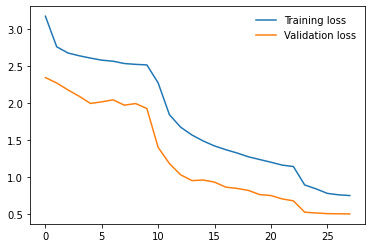

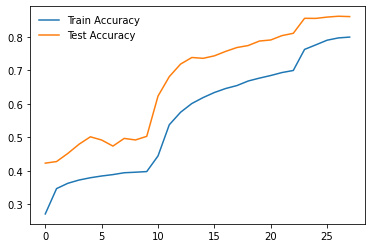

In [ ]:
# Plot metrics
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.savefig(os.path.join('drive/MyDrive/Thesis/log/losses.jpg'), transparent=True, dpi=200)
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Test Accuracy')
plt.legend(frameon=False)
plt.savefig(os.path.join('drive/MyDrive/Thesis/log/accuracies.jpg'), transparent=True, dpi=200)
plt.show()

# Evaluation

In [10]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Print the Validation Loss and Total Epochs
valid_loss = checkpoint["valid_loss_min"] 
num_epoch  = checkpoint['epochs']
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

We have reached the 28th epoch and a validation loss of 0.5052


In [30]:
######################    
# Evaluate the model #    
######################     
test_loss = 0.0
true_class = list(0. for i in range(len(classes)))
total_class = list(0. for i in range(len(classes)))
y_true, y_pred = [], []
top5_accuracy = 0

model.cuda()
model.eval()

with torch.no_grad():
    for data, target in tq.tqdm(test_loader):
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        ## For 10-crop Testing
        bs, ncrops, c, h, w = data.size()
        # Forward pass: compute predicted outputs 
        temp_output = model(data.view(-1, c, h, w))
        output = temp_output.view(bs, ncrops, -1).mean(1)
        # Calculate the loss
        loss = criterion(output, target)
        # Update average evaluation loss 
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        _, pred_top5 = torch.topk(output, 5)
        # Comparing true and predicted labels
        true_labels = pred.eq(target.data.view_as(pred))
        true_labels = np.squeeze(true_labels.numpy()) if not train_on_gpu else np.squeeze(true_labels.cpu().numpy())
        # Examine top-5 predicted labels
        for i in range(target.shape[0]):
            for j in range(pred_top5[i].shape[0]):
                if target[i] == pred_top5[i][j]:
                    top5_accuracy += 1
                    break
        # Calculate class-wise accuracy
        for i in range(len(target)):
            label = target.data[i]
            true_class[label]  += true_labels[i].item() 
            total_class[label] += 1
        # Calculate the confusion matrix
        for i in range(len(target)):
            y_true.append(target[i].cpu().numpy())
            y_pred.append(pred[i].cpu().numpy())

# Calculate average loss
val_loss = test_loss/len(test_loader.dataset)

# Calculate test top-5 accuracy
top5_accuracy /= len(test_loader.dataset)

# Print per class accuracies
for i in range(len(classes)):
    print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (classes[i], 100 * true_class[i] / total_class[i], np.sum(true_class[i]), np.sum(total_class[i])))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (100. * np.sum(true_class) / np.sum(total_class), np.sum(true_class), np.sum(total_class)))
print('\nTop-5 Test Accuracy (Overall): %.2f%% ' % (100. * top5_accuracy))

  0%|          | 0/1579 [00:00<?, ?it/s]

Test Accuracy of apple_pie: 64.40% (161/250)
Test Accuracy of baby_back_ribs: 80.40% (201/250)
Test Accuracy of baklava: 93.60% (234/250)
Test Accuracy of beef_carpaccio: 91.60% (229/250)
Test Accuracy of beef_tartare: 85.60% (214/250)
Test Accuracy of beet_salad: 81.20% (203/250)
Test Accuracy of beignets: 89.60% (224/250)
Test Accuracy of bibimbap: 94.00% (235/250)
Test Accuracy of bread_pudding: 69.60% (174/250)
Test Accuracy of breakfast_burrito: 74.80% (187/250)
Test Accuracy of bruschetta: 76.40% (191/250)
Test Accuracy of caesar_salad: 90.80% (227/250)
Test Accuracy of cannoli: 90.80% (227/250)
Test Accuracy of caprese_salad: 91.60% (229/250)
Test Accuracy of carrot_cake: 85.20% (213/250)
Test Accuracy of ceviche: 80.00% (200/250)
Test Accuracy of cheesecake: 94.00% (235/250)
Test Accuracy of cheese_plate: 77.60% (194/250)
Test Accuracy of chicken_curry: 83.60% (209/250)
Test Accuracy of chicken_quesadilla: 88.80% (222/250)
Test Accuracy of chicken_wings: 91.20% (228/250)
Test A

In [ ]:
# Save predictions and targets
with open('drive/MyDrive/Thesis/log/y_true.pkl', 'wb') as f:
    pickle.dump(y_true, f)

with open('drive/MyDrive/Thesis/log/y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

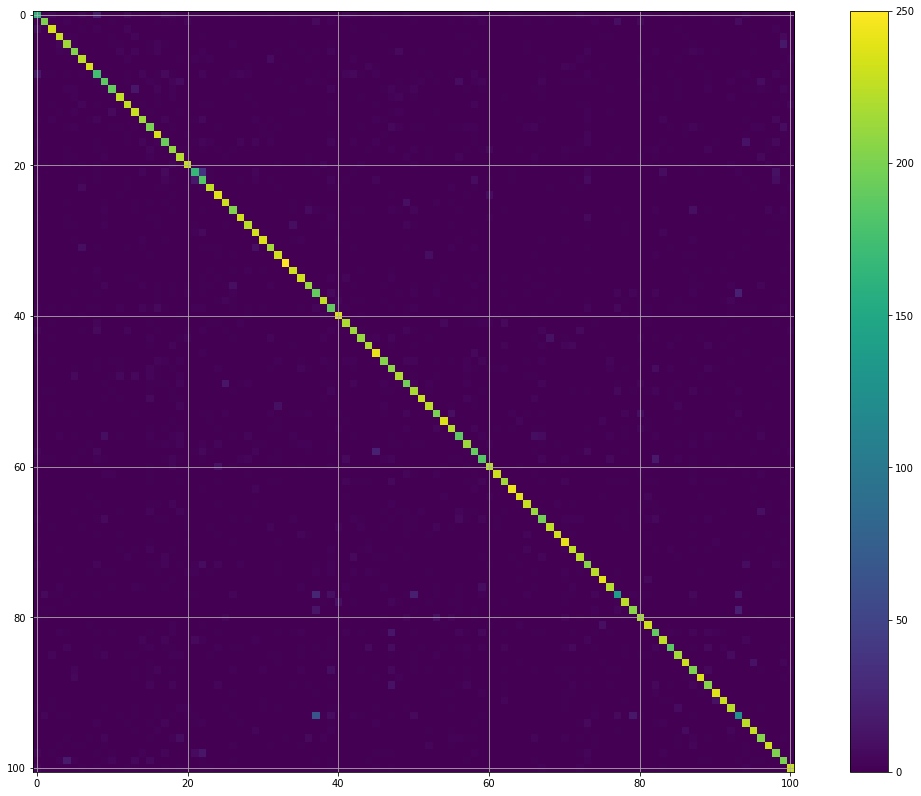

In [ ]:
# Load vectors
with open('drive/MyDrive/Thesis/log/y_pred.pkl', 'rb') as f:
    y_pred = pickle.load(f)

with open('drive/MyDrive/Thesis/log/y_true.pkl', 'rb') as f:
    y_true = pickle.load(f)

# Confusion Matrix 
import pandas as pd
import seaborn as sn
cm = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cm)
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True)
plt.figure(figsize = (20,14))
plt.imshow(cm, interpolation='none')
plt.colorbar()

plt.grid(True)
plt.show()

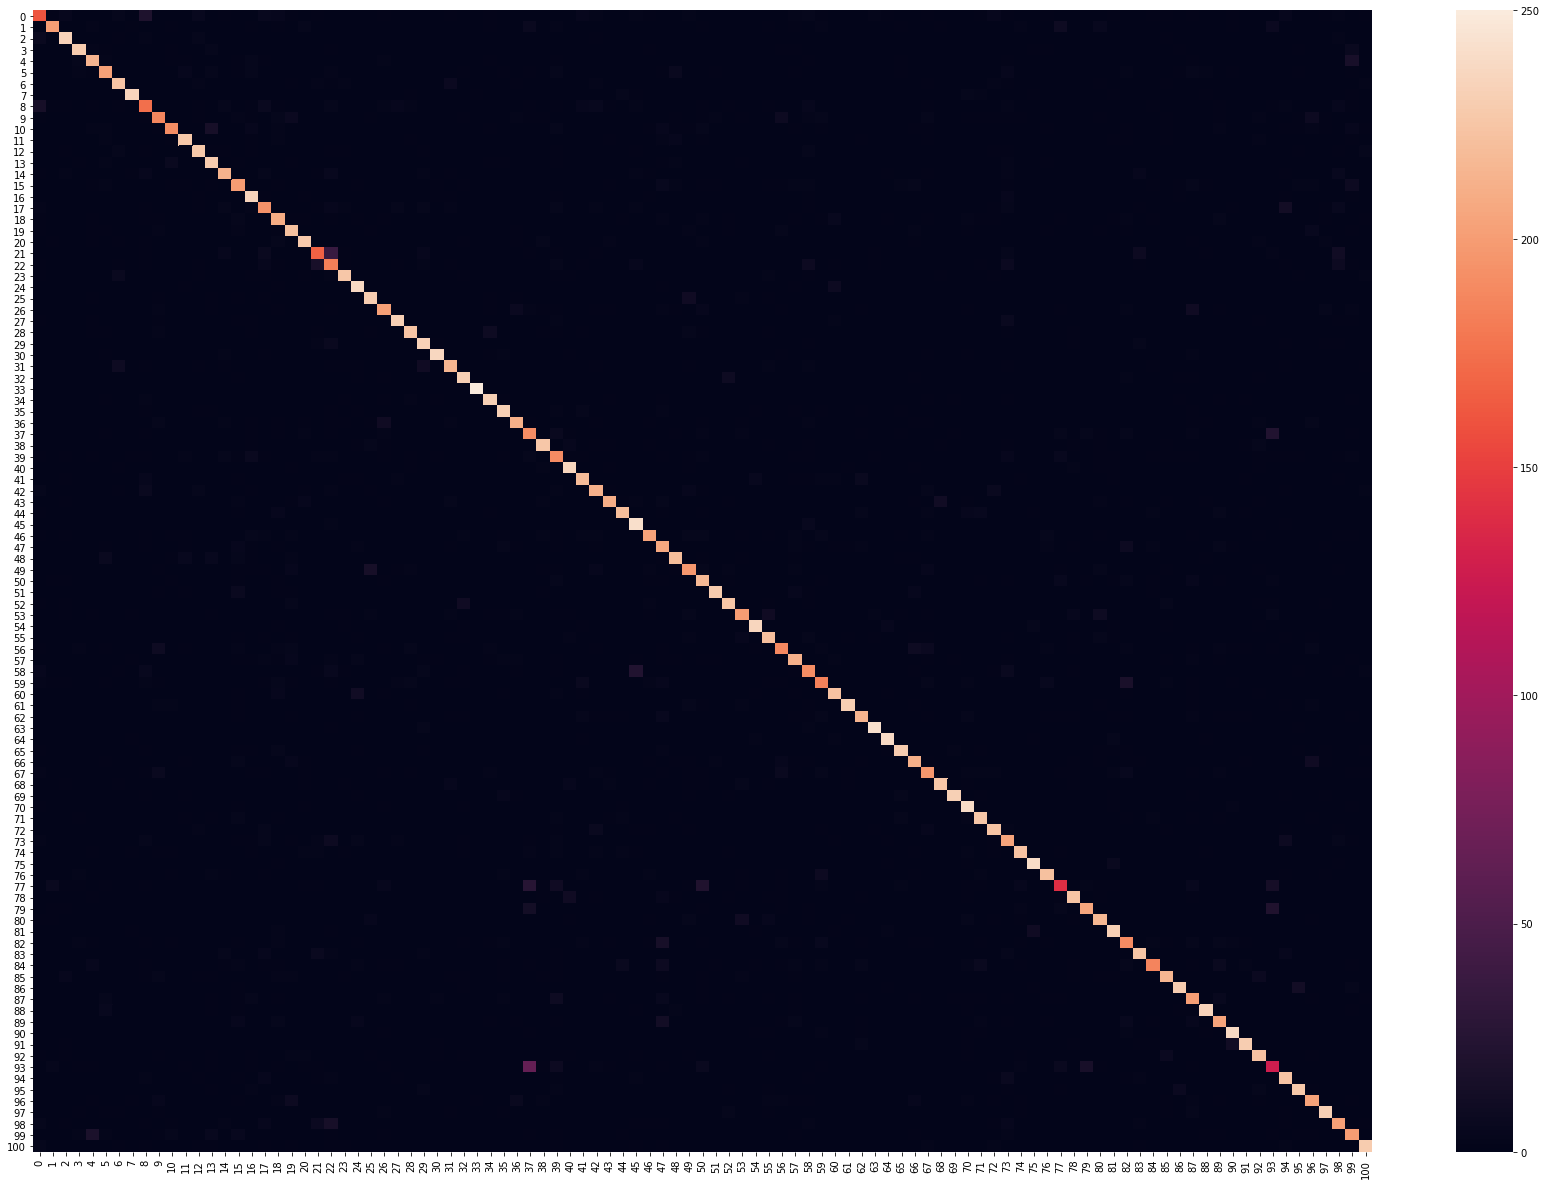

In [ ]:
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (30,21))
sn.heatmap(df_cm, annot=False)